<a href="https://colab.research.google.com/github/rodrigorenemenegazzo/Python_QuantumComputing/blob/main/Projeto_final_Problema_do_Caixeiro_Viajante_com_4_cidades_usando_Algoritmo_QAOA_em_Qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Projeto final - Problema do Caixeiro Viajante com 4 cidades usando Algoritmo QUBO e QAOA em Qiskit

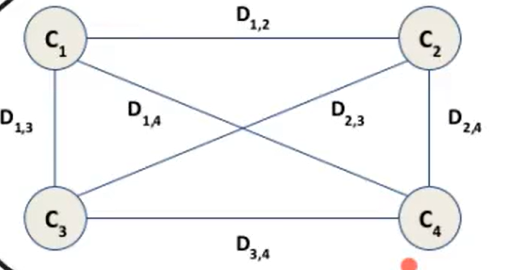

In [3]:
!pip install qiskit qiskit_algorithms qiskit_optimization
!pip install matplotlib numpy

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.quantum_info import SparsePauliOp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import QAOA

##Definição da matriz de distância das cidades

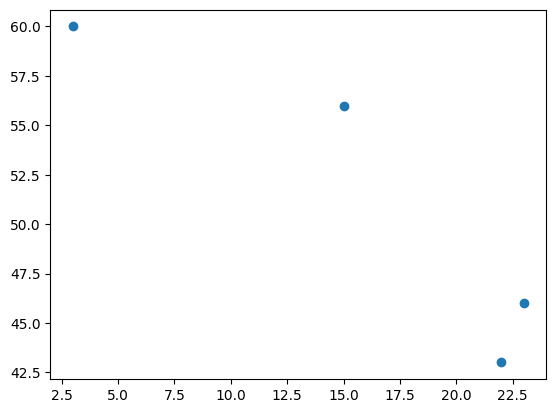


 Matriz de distâncias D:
São Paulo     :   0.00    3.16   12.81
Rio de Janeiro:   3.16    0.00   14.76
Manaus        :  12.81   14.76    0.00



In [3]:
#cidades = ["São Paulo", "Rio de Janeiro", "Cuiabá", "Manaus"]
cidades = ["São Paulo", "Rio de Janeiro", "Manaus"]


# Coordenadas inventadas baseadas em coordenadas geográficas
coords_deg = {
    "São Paulo":     (23, 46),
    "Rio de Janeiro":(22, 43),
    "Cuiabá":        (15, 56),
    "Manaus":        ( 3, 60),
}

def calc_dist(px1, px2, py1, py2):
  return math.sqrt((px1 - px2)**2 + (py1 - py2)**2)

x = []
y = []

for c in coords_deg.values():
  x.append(c[0])
  y.append(c[1])

plt.scatter(x, y)
plt.show()

n = len(cidades)
D = np.zeros((n, n))
for i in range(n):
  for j in range(n):
    if i == j:
      D[i, j] = 0
    else:
      D[i, j] = calc_dist(x[i], x[j], y[i], y[j] )

print("\n Matriz de distâncias D:")
for i in range(n):
    row = "  ".join(f"{D[i,j]:6.2f}" for j in range(n))
    print(f"{cidades[i]:14s}: {row}")
print()


##Criando instância da classe quadraticProgram QUBO- Definindo o objetivo quadrático no QuadraticProgram

In [4]:
problema = QuadraticProgram(name="Problema do caixeiro viajante - 4 cidades")

#variáveis binárias com nomes "x_i_p"
for i in range(n):
    for p in range(n):
        problema.binary_var(name=f"x_{i}_{p}")

## Restrições lineares

In [5]:
# cada posição p tem exatamente 1 cidade
for p in range(n):
    linear = {f"x_{i}_{p}": 1 for i in range(n)}
    problema.linear_constraint(linear=linear, sense="==", rhs=1, name=f"posicao_{p}")

# cada cidade pode aparecer 1 vez
for i in range(n):
    linear = {f"x_{i}_{p}": 1 for p in range(n)}
    problema.linear_constraint(linear=linear, sense="==", rhs=1, name=f"cidade_{i}")


## Criando os termos quadraticos

In [6]:
# OBJETIVO: minimizar distância total
quad_terms = {}
for p in range(n):
    pnext = (p + 1) % n
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            var_i = f"x_{i}_{p}"
            var_j = f"x_{j}_{pnext}"
            key = (var_i, var_j)
            quad_terms[key] = quad_terms.get(key, 0.0) + float(D[i, j])

##Definindo a função de custo

In [7]:
# Objetivo quadrático no QuadraticProgram
problema.minimize(quadratic=quad_terms)

/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


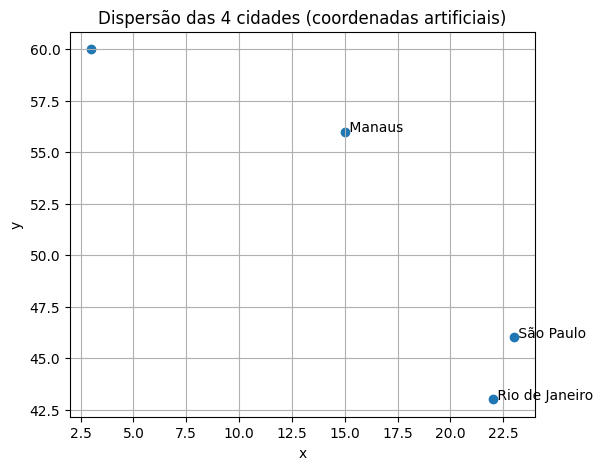

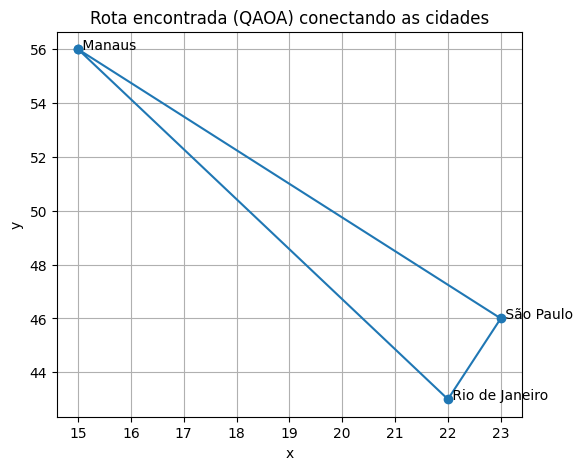

Rota encontrada (QAOA):
Manaus -> São Paulo -> Rio de Janeiro -> Manaus
Valor objetivo retornado (fval): 30.7333



In [8]:
# Converte QuadraticProgram para QUBO
qp_qubo = QuadraticProgramToQubo().convert(problema)

# Prepara QAOA:
sampler = StatevectorSampler()
optimizer = COBYLA(maxiter=150)
qaoa = QAOA(sampler=sampler, reps=2, optimizer=optimizer)
meo = MinimumEigenOptimizer(qaoa)
result = meo.solve(qp_qubo)

# Extrai a rota a partir da solução binária
def extrair_rota(result, n, cidades):
    x_vals = result.x
    rota_pos = [None] * n
    for var, val in zip(result.variables, x_vals):
        if round(val) == 1:

            parts = var.name.split("_")
            i = int(parts[1])
            p = int(parts[2])
            rota_pos[p] = i
    # converte índices em nomes de cidade
    rota_nomes = [cidades[idx] for idx in rota_pos]
    return rota_nomes

rota_qaoa = extrair_rota(result, n, cidades)

# Dispersão das cidades sem as rotas
plt.figure(figsize=(6,5))
plt.scatter(x, y)
for i, nome in enumerate(cidades):
    plt.text(x[i], y[i], " " + nome)
plt.title("Dispersão das 4 cidades (coordenadas artificiais)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

# Grafico com as rotas
indices_rota = [cidades.index(c) for c in rota_qaoa] + [cidades.index(rota_qaoa[0])]
route_x = [x[idx] for idx in indices_rota]
route_y = [y[idx] for idx in indices_rota]

plt.figure(figsize=(6,5))
plt.plot(route_x, route_y, marker='o')
for i, nome in enumerate(cidades):
    plt.text(x[i], y[i], " " + nome)
plt.title("Rota encontrada (QAOA) conectando as cidades")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

# imprimi rota e mostra retorno a origem:
print("Rota encontrada (QAOA):")
print(" -> ".join(rota_qaoa + [rota_qaoa[0]]))
print(f"Valor objetivo retornado (fval): {result.fval:.4f}")
print()